In [2]:
#connect google colab with google drive
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
#import the libraries to load dataset
import zipfile
import os

#opens file in readmode
zip_ref = zipfile.ZipFile('/content/gdrive/MyDrive/MajorProject/br35hdataset.zip')

#extracts the files into the /MajorProject folder
zip_ref.extractall('/content/gdrive/MyDrive/MajorProject')

#close the file
zip_ref.close()

**Importing necessary modules**

In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
#from sklearn.model_selection import train_test_split
#from sklearn.metrics import f1_score
#from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import time
import sys
import math
import shutil
#from os import listdir

In [4]:
#initializing variables
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [5]:
#loading the dataset into tensorflow dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/gdrive/MyDrive/MajorProject/br35hdataset",
    seed=123,
    shuffle=True,
    batch_size=BATCH_SIZE
)

Found 3000 files belonging to 7 classes.


In [6]:
#determining the class names
class_names = dataset.class_names
class_names

['.ipynb_checkpoints',
 'no',
 'no_augmented',
 'total_no',
 'total_yes',
 'yes',
 'yes_augmented']

In [7]:
import os

# Define the folder path
folder_path_no = '/content/gdrive/MyDrive/MajorProject/br35hdataset/no'
folder_path_yes = '/content/gdrive/MyDrive/MajorProject/br35hdataset/yes'

# Get a list of the files in the folder
filenames_no = os.listdir('/content/gdrive/MyDrive/MajorProject/br35hdataset/no')
filenames_yes = os.listdir('/content/gdrive/MyDrive/MajorProject/br35hdataset/yes')

# Filter the list to include only image files
image_filenames_no = [filename for filename in filenames_no]
image_filenames_yes = [filename for filename in filenames_yes]

# Print the number of images
print(f'Number of images in "no" folder: {len(image_filenames_no)}')
print(f'Number of images in "yes" folder: {len(image_filenames_yes)}')

Number of images in "no" folder: 1500
Number of images in "yes" folder: 1500


#Visualise the dataset

In [8]:
#gives one batch of images
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy()) #every element is a tensor so converting to a numpy

(32, 256, 256, 3)
[5 1 1 5 1 1 5 5 5 1 5 1 1 5 1 5 1 1 1 5 1 5 1 1 5 5 1 5 1 5 1 5]


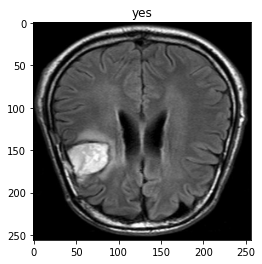

In [9]:
for image_batch, labels_batch in dataset.take(1):
  plt.imshow(image_batch[0].numpy().astype("uint8"))
  plt.title(class_names[labels_batch[0]])
  #plt.axis("off")

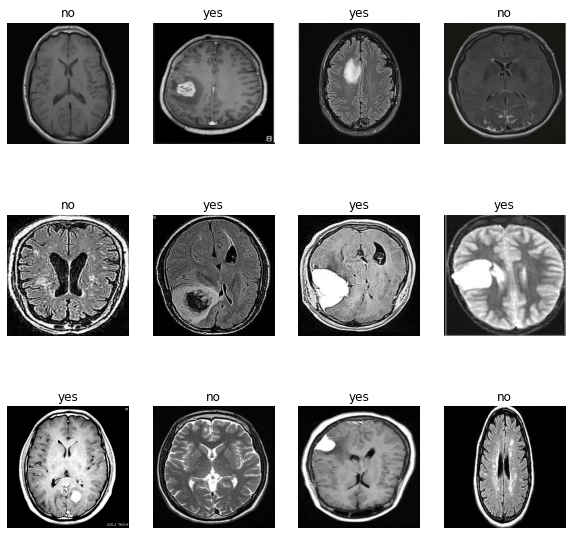

In [10]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

#Data Augmentation


each image is augmented 5 times and stored in a folder

In [11]:
import os
import cv2
import imgaug as ia
import numpy as np
from imgaug import augmenters as iaa

num_augmentations = 5

# Load all images in the dataset directory 'no'
dataset_dir_no = '/content/gdrive/MyDrive/MajorProject/br35hdataset/no'
images_no = [cv2.imread(os.path.join(dataset_dir_no, filename)) for filename in os.listdir(dataset_dir_no)]

# Load all images in the dataset directory 'yes'
dataset_dir = '/content/gdrive/MyDrive/MajorProject/br35hdataset/yes'
images = [cv2.imread(os.path.join(dataset_dir, filename)) for filename in os.listdir(dataset_dir)]

# Define augmentation sequence
seq = iaa.Sequential([
    iaa.Flipud(0.5), # randomly flip vertically with 50% probability
    iaa.Flipud(0.5), # flip images vertically with 50% probability
    iaa.Affine(rotate=(-45, 45)), # randomly rotate images),
    iaa.AdditiveGaussianNoise(scale=(0, 0.05*255)), # add random noise    
    iaa.Multiply((0.8, 1.2), per_channel=0.5) # randomly adjust brightness
], random_order=True) # apply augmentations in random order

# Augment and save images 'no'
augmented_dir_no = '/content/gdrive/MyDrive/MajorProject/br35hdataset/no_augmented'
if not os.path.exists(augmented_dir_no):
    os.makedirs(augmented_dir_no)
for i, image in enumerate(images_no):
    for j in range(num_augmentations):
        augmented = seq(images=np.array([image]))[0]
        filename = f"no_{i}_{j}.jpg"
        cv2.imwrite(os.path.join(augmented_dir_no, filename), augmented)

# Load all images in the dataset directory 'yes'
# Augment and save images
augmented_dir = '/content/gdrive/MyDrive/MajorProject/br35hdataset/yes_augmented'
if not os.path.exists(augmented_dir):
    os.makedirs(augmented_dir)
for i, image in enumerate(images):
    for j in range(num_augmentations):
        augmented = seq(images=np.array([image]))[0]
        filename = f"y_{i}_{j}.jpg"
        cv2.imwrite(os.path.join(augmented_dir, filename), augmented)

number of augmented images

In [12]:
folder = '/content/gdrive/MyDrive/MajorProject/br35hdataset/no_augmented'
image_count = len([f for f in os.listdir(folder) if f.endswith('.jpg')])
print(f"Number of images in {folder}: {image_count}")

Number of images in /content/gdrive/MyDrive/MajorProject/br35hdataset/no_augmented: 7500


copy the contents of 'no' folder and 'augmentes_images_no' into 'total_no' folder

In [13]:
import shutil

src_folder1 = '/content/gdrive/MyDrive/MajorProject/br35hdataset/no'
src_folder2 = '/content/gdrive/MyDrive/MajorProject/br35hdataset/no_augmented'
dst_folder = '/content/gdrive/MyDrive/MajorProject/br35hdataset/total_no'

# Copy all files in folder1 to dst_folder
for filename in os.listdir(src_folder1):
    src = os.path.join(src_folder1, filename)
    dst = os.path.join(dst_folder, filename)
    shutil.copy2(src, dst)

# Copy all files in folder2 to dst_folder
for filename in os.listdir(src_folder2):
    src = os.path.join(src_folder2, filename)
    dst = os.path.join(dst_folder, filename)
    shutil.copy2(src, dst)


In [18]:
src_fol1 = '/content/gdrive/MyDrive/MajorProject/br35hdataset/yes'
src_fol2 = '/content/gdrive/MyDrive/MajorProject/br35hdataset/yes_augmented'
dst_folr = '/content/gdrive/MyDrive/MajorProject/br35hdataset/total_yes'

# Copy all files in folder1 to dst_folder
for filename in os.listdir(src_fol1):
    src1 = os.path.join(src_fol1, filename)
    dst1 = os.path.join(dst_folr, filename)
    shutil.copy2(src1, dst1)

# Copy all files in folder2 to dst_folder
for filename in os.listdir(src_fol2):
    src1 = os.path.join(src_fol2, filename)
    dst1 = os.path.join(dst_folr, filename)
    shutil.copy2(src1, dst1)

In [20]:
folder = '/content/gdrive/MyDrive/MajorProject/br35hdataset/total_yes'
image_count = len([f for f in os.listdir(folder) if f.endswith('.jpg')])
print(f"Number of images in {folder}: {image_count}")

Number of images in /content/gdrive/MyDrive/MajorProject/br35hdataset/total_yes: 9000


Splitting the dataset such that


*   Train data : 80%
*   Test data: 10%

*   Validation: 10%








